In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev
#import healpy as hp
import numpy as np


from tools import *
from tools import _trans
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os, scipy, sys

In [4]:
sindec_bins = np.linspace(-1,1,100)
sindec_mids = (sindec_bins[1:]+sindec_bins[:-1])/2.
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

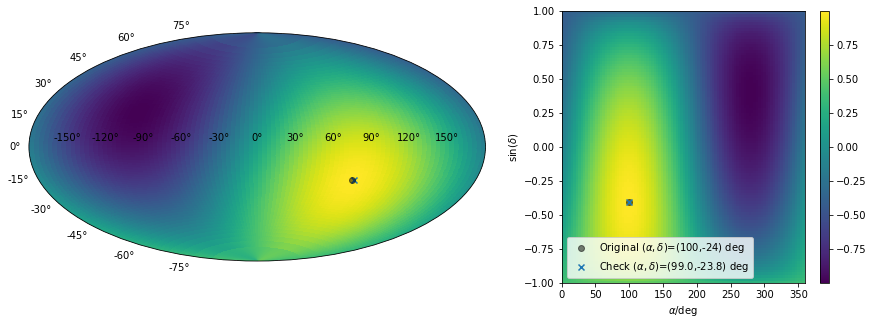

In [5]:
# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

# get the index of the max pixel for cross check
ira, isd = np.unravel_index(dipole.argmax(), dipole.shape)

# plot with aitoff and rectangular projection for cross check
fig = plt.figure(figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 2])
ax = fig.add_subplot(spec[0], projection="aitoff")
ax2 = fig.add_subplot(spec[1])

# aitoff plot with coordinate trafo
ax.pcolormesh(*np.meshgrid(np.pi - ra_bins, np.arcsin(sindec_bins)),
    dipole.T # transpose for plotting
             )

ax.scatter(np.pi-ra_mids[ira], np.arcsin(sindec_mids[isd]), marker="x")
ax.scatter(
    np.pi - alpha_d_radian, delta_d_radian,
    marker="o",
    alpha=0.5,
    color="k"
)

# rectangular plot in RA/deg and sin(dec)
xx,yy=np.meshgrid(np.rad2deg(ra_bins), sindec_bins)
im = ax2.pcolormesh(
    xx,yy,
    dipole.T # transpose for plotting
)
plt.colorbar(im, ax=ax2, aspect=30, use_gridspec=True)
# original dipole axis
ax2.scatter(
    alpha_d, np.sin(delta_d_radian),
    marker="o",
    alpha=0.5,
    color="k",
    label=r"Original $(\alpha, \delta)$=({},{}) deg".format(
        alpha_d, 
        delta_d, 
    )
)
# cross check dipole axis
ax2.scatter(
    np.rad2deg(ra_mids[ira]), sindec_mids[isd],
    marker="x", 
    label=r"Check $(\alpha, \delta)$=({:1.1f},{:1.1f}) deg".format(
        np.rad2deg(ra_mids[ira]), 
        np.rad2deg(np.arcsin(sindec_mids[isd])), 
    )
)
ax2.set_xlim(0, 360)
ax2.set_xlabel(r"$\alpha$/deg")
ax2.set_ylabel(r"$\sin(\delta)$")
ax2.legend(loc=3)

# Now we want to test if we can also see this dipole in neutrinos and if we can distinguish this from a uniform distribution

Define a llh ratio test based on a poisson pdf
$\mathcal{L} = \prod_i \frac{(\lambda^i_b+\lambda^i_s)^{k_i}}{k_i!} e^{-(\lambda^i_b+\lambda^i_s)}$ 

where i runs over all bins. 
* The background hypothesis is that we have atmospheric background $\lambda_b$ and a uniform astrophysical part $\lambda_s(\alpha, \sin(\delta)) = \int  A_{\mathrm{eff}}(\sin(\delta), E) \phi^{uni}_0(\alpha, \sin(\delta)) \left(\frac{E}{E_0}\right)^{-\gamma} dE$, where $\phi^{uni}_0(\alpha, \sin(\delta))=\phi_0$ 
* For the signal hypotheis on the other we assume that the astrophysical flux can be described a uniform component and a non_uniform part connected to the CR dipole, yielding $\phi^{dip}_0(\alpha, \sin(\delta)) = \phi_0^* (1-A_d) + \phi_0^* A_d \phi_d(\alpha, \sin(\delta))$, where $A_d$ is the dipole amplitude and $\phi_d(\alpha, \sin(\delta))$ the dipole shape

# The test statistic function

$\Lambda = 2\log \frac{\max_{\theta in H_s}\mathcal{L}(\theta|D)}{\max_{\theta in H_b}\mathcal{L}(\theta|D)}= 2 \sum_i k_i \log\left( \frac{\lambda_b+\lambda^{dip}_s}{\lambda_b+\lambda^{uni}_s}\right) - \lambda^{dip}_s + \lambda^{uni}_s$ 

the sum runs over all bins (we will use a binning in ra, sin(dec) and maybe energy)

* $\lambda_s^{uni}(\alpha, \sin(\delta)) = \int  A_{\mathrm{eff}}(\sin(\delta), E) \phi_0 \left(\frac{E}{E_0}\right)^{-\gamma} dE$  

* $\lambda_s^{dip}(\alpha, \sin(\delta)) = \int  A_{\mathrm{eff}}(\sin(\delta), E) \phi^{dip}_0(\alpha, \sin(\delta)) \left(\frac{E}{E_0}\right)^{-\gamma} dE $

* $\lambda_b$: background expectation from MCEq

# Get the background expectations in each bin

In [6]:
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm

In [7]:
base_model = 'SIBYLL23C'
mceq = MCEqRun(
    interaction_model=base_model,
    theta_deg=0.,
    #primary_model= (pm.HillasGaisser2012, "H3a"),
    primary_model=(pm.GlobalSplineFitBeta,
             '/Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2')
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta /Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2


In [8]:
mag = 0


#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(0.5,0,3))*180./np.pi

flux_def = dict()
#Initialize empty grid
for frac in ['numu_conv','numu_pr','numu_total',
             'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = np.zeros_like(mceq.e_grid)

    
#Sum fluxes, calculated for different angles
for theta in angles:
    mceq.set_theta_deg(theta)
    mceq.solve()
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['mu_conv'] += (mceq.get_solution('conv_mu+', mag)
                         + mceq.get_solution('conv_mu-', mag))

    flux_def['mu_pr'] += (mceq.get_solution('pr_mu+', mag)
                       + mceq.get_solution('pr_mu-', mag))

    flux_def['mu_total'] += (mceq.get_solution('total_mu+', mag)
                          + mceq.get_solution('total_mu-', mag))
    
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['numu_conv'] += (mceq.get_solution('conv_numu', mag)
                         + mceq.get_solution('conv_antinumu', mag))

    flux_def['numu_pr'] += (mceq.get_solution('pr_numu', mag)
                       + mceq.get_solution('pr_antinumu', mag))

    flux_def['numu_total'] += (mceq.get_solution('total_numu', mag)
                          + mceq.get_solution('total_antinumu', mag))

    # same meaning of prefixes for electron neutrinos as for muons
    flux_def['nue_conv'] += (mceq.get_solution('conv_nue', mag)
                        + mceq.get_solution('conv_antinue', mag))

    flux_def['nue_pr'] += (mceq.get_solution('pr_nue', mag)
                      + mceq.get_solution('pr_antinue', mag))

    flux_def['nue_total'] += (mceq.get_solution('total_nue', mag)
                         + mceq.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux_def['nutau_pr'] += (mceq.get_solution('total_nutau', mag)
                        + mceq.get_solution('total_antinutau', mag))

#average the results
for frac in [
             'numu_conv','numu_pr','numu_total',
            'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = flux_def[frac]/float(len(angles))

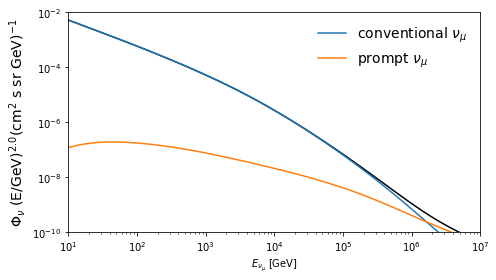

In [9]:
fig, ax = plt.subplots( figsize=(7,4))
e_grid = mceq.e_grid

fs=14
spec = 2.
for i,(pref, lab) in enumerate([('numu_',r'\nu_\mu')]):
    
    p0 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'total'], color='k', ls='solid', lw=1.5)
    p1 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'conv'],  ls='solid', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    p2 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'pr'], ls='solid', lw=1.5, 
               label='prompt ${0}$'.format(lab))
    
    
    
    ax.set_xlim(10,1e7)
    
    ax.set_ylim(1e-10,1e-2)
    #ax.set_ylim(0.8,1.2)
    ax.set_xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    
    ax.legend(loc='upper right',frameon=False,numpoints=1,fontsize=fs)

ax.set_ylabel(r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) +" }$" + 
           "(cm$^{2}$ s sr GeV)$^{-1}$", fontsize=fs)
    
    

fig.tight_layout()

# Now use the effective areas that i created for plenum to get signal and background event number descriptions

In [10]:
path = 'resources/'
results = np.load(os.path.join(path, 'effective_areas_av_per_day_fine_binning.npy'))

etrue_bins = np.arange(2,8.1,0.1) # np.linspace(2.,9.,num=25)
etrue_mids = 10**((etrue_bins[1:]+etrue_bins[:-1])/2.)
etrue_bins = 10**etrue_bins

sd_bins = np.linspace(-1.,1.,35)
n_sd, n_e = len(sd_bins)-1, len(etrue_bins)-1

etrue_bin_width = np.diff(etrue_bins)

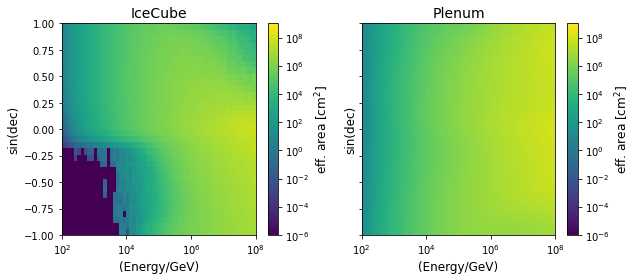

In [11]:
fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)
effA_splines = dict()

ax = axes[0]
ax.set_title('IceCube', fontsize=14)
p = ax.pcolormesh(etrue_bins, sd_bins, #Res_effA*1e4
                  results['effA_icecube'].reshape((n_sd, n_e)) 
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)

binmids = ( get_mids(sd_bins, ext=True), etrue_mids)
#print(etrue_mids.shape, sd_bins.shape, np.log(results['effA_icecube'].reshape((n_sd, n_e))).shape)
effA_spline_ice = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(results['effA_icecube'].reshape((n_sd, n_e))),
                    method="linear",
                    bounds_error=False,
                    fill_value=-10.
                    )

effA_splines['icecube'] = effA_spline_ice


ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)
ax.set_xscale('log')

ax = axes[1]
ax.set_title('Plenum', fontsize=14)
p = ax.pcolormesh(etrue_bins, sd_bins,
                  results['effA_plenum'].reshape((n_sd, n_e))  
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)
effA_spline_plenum = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(results['effA_plenum'].reshape((n_sd, n_e))),
                    method="linear",
                    bounds_error=False,
                    fill_value=-10.
                    )
effA_splines['plenum'] = effA_spline_plenum

ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)


ax.set_xscale('log')
fig.tight_layout()

# Get also the public energy smearing function 

In [12]:
ereco_bins = np.arange(2,7.1,0.1) # np.linspace(2.,9.,num=25)
ereco_mids = 10**get_mids(ereco_bins)
ereco_bins = 10**ereco_bins

n_ereco = len(ereco_mids)

In [13]:
d_public_2021_smearing = np.genfromtxt('/Users/mhuber/Downloads/icecube_10year_ps/irfs/IC86_II_smearing.csv',
                        skip_header=1)

In [14]:
log_emin_smearing, log_emax_smearing = d_public_2021_smearing[:,0], d_public_2021_smearing[:,1]
log_emids_smearing = (log_emin_smearing+log_emax_smearing)/2.
sdec_min_smearing, sdec_mac_smearing = (np.sin(np.deg2rad(d_public_2021_smearing[:,2])), 
                      np.sin(np.deg2rad(d_public_2021_smearing[:,3])))

log_erec_min_smearing, log_erec_max_smearing = d_public_2021_smearing[:,4], d_public_2021_smearing[:,5]
log_erec_mids_smearing = (log_erec_min_smearing+log_erec_max_smearing)/2.

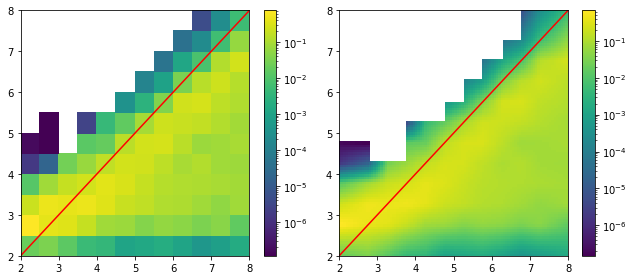

In [15]:
fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(9,4))
counts = d_public_2021_smearing[:,-1]



    
    
bins = (np.arange(2,8.1,0.5), np.arange(2,8.1,0.5))
h,_,_= np.histogram2d(log_emids_smearing,log_erec_mids_smearing, 
          bins=bins, weights=counts)

h = h / h.sum(axis=1)[:,np.newaxis]


binmids = tuple([get_mids(bi, ext=True) for bi in bins])
smearing_spline = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(h),
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                    )

ax = axes[0]
p=ax.pcolormesh(bins[0], bins[1], h.T, norm=LogNorm())
ax.plot([2,8], [2,8], color='red')
cb=fig.colorbar(p,ax=ax)

ax = axes[1]
grid_etrue = np.linspace(bins[0][0], bins[0][-1],100) 
grid_ereco = np.linspace(bins[1][0], bins[1][-1],100) 

xx,yy = np.meshgrid(grid_etrue, grid_ereco,indexing='ij')

p=ax.pcolormesh(grid_etrue, grid_ereco, np.exp(smearing_spline((xx, yy))).T, norm=LogNorm())
ax.plot([2,8], [2,8], color='red')
cb=fig.colorbar(p,ax=ax)

    
fig.tight_layout()

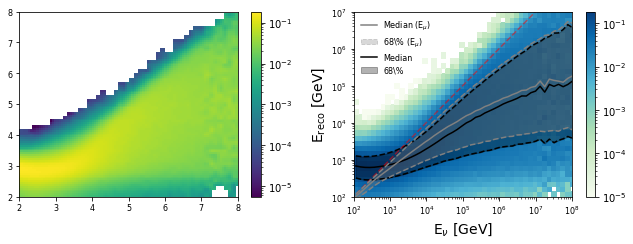

In [16]:
fs_ticks=12
sys.path.append('/Users/mhuber/Python_Tools/')
from my_functions import weighted_median
idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
k_mc = 'muon_energy_entry'
mask = np.isnan(idata[k_mc])
idata = idata[~mask]


bins_reco = np.linspace(2, 8.1, 45)
mids_reco = 10**get_mids(bins_reco)
bins_reco = 10**bins_reco



fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9,3.5), squeeze=True) 
ax = axes[1]

k_mc = 'trueE'
k_reco = 'energy'
bins_mc = np.linspace(2, 8.2, 50)
mids_mc = 10**get_mids(bins_mc)
bins_mc = 10**bins_mc


gamma=2.
w = np.ones_like(idata['ow'])# * idata['trueE']**(-gamma)# np.ones_like(idata[k_mc])
h,_,_ = np.histogram2d(idata[k_mc], idata[k_reco], bins = (bins_mc, bins_reco), weights=w)
# normalize along the mc axis to get P(E_reco| E_entry)
norm = h.sum(axis=1)
norm[norm==0] = 1.
h /= norm[:,np.newaxis]

binmids = tuple([get_mids(bi, ext=True) for bi in (np.log10(bins_mc), np.log10(bins_reco))])
smearing_spline = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(h),
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                    )

grid_etrue = np.linspace(bins[0][0], bins[0][-1],100) 
grid_ereco = np.linspace(bins[1][0], bins[1][-1],100) 

xx,yy = np.meshgrid(grid_etrue, grid_ereco,indexing='ij')
p=axes[0].pcolormesh(grid_etrue, grid_ereco, np.exp(smearing_spline((xx, yy))).T, norm=LogNorm())
fig.colorbar(p, ax=axes[0])


med_low,_  = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, (1-0.68)/2.)
med_up,_  = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, 1-(1-0.68)/2.)
med50,_ = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, 0.5)


p = ax.pcolormesh( bins_mc, bins_reco, h.T, norm=LogNorm(), cmap='GnBu', vmin=1e-5, vmax=h.max())
cb = fig.colorbar(p, ax=ax)
#cb.set_label(r'P(E$_{\mathrm{reco}}$ $|$ E$_{\nu}$)', fontsize=fs)

c = 'black'
ax.plot(mids_mc, med50, color=c, label=r'Median')
ax.plot(mids_mc, med_low, ls='dashed', color=c)
ax.plot(mids_mc, med_up, ls='dashed', color=c)
ax.fill_between(mids_mc, med_low,med_up, color=c, alpha=0.3,  label=r'68\%')

ax.plot([1,1e7],[1,1e7], ls='dashed', color='red', alpha=0.5)

# also show the actual deviation between muon (entry) and neutrino energy
med_low,_  = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, (1-0.68)/2.)
med_up,_  = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, 1-(1-0.68)/2.)
med50,_ = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, 0.5)

c = 'grey'
ax.plot(mids_mc, med50, color=c, label=r'Median (E$_{\mu}$)')
ax.plot(mids_mc, med_low, ls='dashed', color=c)
ax.plot(mids_mc, med_up, ls='dashed', color=c)
ax.fill_between(mids_mc, med_low,med_up, color=c, alpha=0.3, linestyle='dashed', label=r'68\% (E$_{\mu}$)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e8)
ax.set_ylim(1e2, 1e7)
ax.set_xlabel(r'E$_{\nu}$ [GeV]', fontsize=fs)
ax.set_ylabel(r'E$_{\mathrm{reco}}$ [GeV]', fontsize=fs)


handles, labels = ax.get_legend_handles_labels()
hmu68 = handles.pop(-1)
h68 = handles.pop(-1)
hmu = handles.pop(-1)
h = handles.pop(-1)
handles.append(hmu)
handles.append(hmu68)
handles.append(h)
handles.append(h68)

ax.legend(handles=handles, frameon=False, loc='upper left', fontsize=fs-6)
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=fs_ticks-4)

fig.tight_layout()

# Now get the background expectations 

In [17]:
from copy import copy

In [89]:
pixel_sizes = ra_width*sindec_width[:,np.newaxis] 
lt = 10*365.25*86400

# use integrated values over energy, but set some lower energy threshold here
# since we will receive data in reco energy bins only this energy makes sense here
_eval = 1e2
em_ind = np.argmin(np.abs(np.log10(ereco_mids) - np.log10(_eval)))


In [90]:
Res_mu = dict()
Res_numu = dict()
Res_mu_prompt = dict()
Res_numu_prompt = dict()

Res_mu_reco = dict()
Res_numu_reco = dict()
Res_mu_prompt_reco = dict()
Res_numu_prompt_reco = dict()


tck_numu = splrep(mceq.e_grid, np.log(flux_def['numu_conv'])  , s=1.e-2)
tck_numu_pr = splrep(mceq.e_grid, np.log(flux_def['numu_pr'])  , s=1.e-2)

tck_mu = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_conv'])[:-1]  , s=1.e-2)
tck_mu_pr = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_pr'])[:-1]  , s=1.e-2)

for exp in ['icecube', 'plenum']:
    
    n_sindec = len(sindec_mids)
    NTOT_numu = np.zeros((n_e,n_sindec), dtype=float)
    NTOT_mu = np.zeros((n_e,n_sindec), dtype=float)
    NTOT_numu_prompt = np.zeros((n_e,n_sindec), dtype=float)
    NTOT_mu_prompt = np.zeros((n_e,n_sindec), dtype=float)

    NTOT_numu_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    NTOT_mu_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    NTOT_numu_prompt_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    NTOT_mu_prompt_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    
    effA = effA_splines[exp]

    for i, sd_i in enumerate(sindec_mids):
        for k,ei in enumerate(etrue_mids):

            
            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_numu))  * etrue_bin_width[k]) 
            
            # flux_def['numu_conv'][ind_mceq][k]
            NTOT_numu[k,i] = Ni
            
            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_numu_pr)) * etrue_bin_width[k])
            #flux_def['numu_pr'][ind_mceq][k] 
            NTOT_numu_prompt[k,i] = Ni

            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_mu)) * etrue_bin_width[k])
            
            #flux_def['mu_conv'][ind_mceq][k]
            NTOT_mu[k,i] = Ni
            
            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_mu_pr)) * etrue_bin_width[k])
            #flux_def['mu_pr'][ind_mceq][k] 
            NTOT_mu_prompt[k,i] = Ni
        
        # Now also get the event rates in reco energy bins
        xx,yy = np.meshgrid(np.log10(etrue_mids), np.log10(ereco_mids), indexing='ij')
        smearing = np.exp(smearing_spline((xx,yy)))
        smearing = smearing / smearing.sum(axis=1)[:,np.newaxis]
    
    
        NTOT_numu_reco[:,i] = np.dot(smearing.T, NTOT_numu[:,i])
        NTOT_mu_reco[:,i] = np.dot(smearing.T, NTOT_mu[:,i])
        NTOT_numu_prompt_reco[:,i] = np.dot(smearing.T, NTOT_numu_prompt[:,i])
        NTOT_mu_prompt_reco[:,i] = np.dot(smearing.T, NTOT_mu_prompt[:,i])
        
    
    # Now also add the right ascension axes and integrate over the pixel size
    # to get the actual number of events in that bin
    Res_mu_reco[exp] = np.sum((NTOT_mu_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...], axis=0)
    Res_numu_reco[exp] = np.sum((NTOT_numu_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...], axis=0)
    Res_mu_prompt_reco[exp] = np.sum((NTOT_mu_prompt_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...], axis=0)
    Res_numu_prompt_reco[exp] = np.sum((NTOT_numu_prompt_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...], axis=0)

11.220184543019675
793837.8950173687
(99, 100)
icecube 755411.406648681


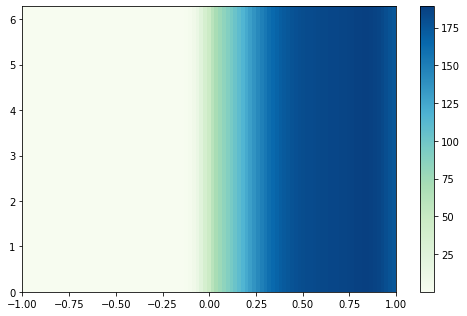

In [91]:
fig, ax = plt.subplots(figsize=(7,4.5))

print(ereco_mids[20]/1.e3)
print(np.sum(Res_numu_reco['icecube']))
print(Res_mu_reco['icecube'].shape)
p = ax.pcolormesh(sindec_bins, ra_bins, Res_numu_reco['icecube'].T, cmap='GnBu', 
                  )
fig.colorbar(p, ax=ax)
fig.tight_layout()


idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
w = (idata['conv']+idata['prompt'])*lt #* idata['trueE']**(-gamma)
print('icecube', np.sum(w))

In [92]:
304702934 / lt 

0.9655453329784267

# Now also get signal expectation values for different phi0, gamma, A_d values

In [116]:
phi100s = 10**np.linspace(-23,-16, 20)
gammas = np.arange(1.5,4.1,0.5)
A_dipole = np.linspace(0,0.3,10)

In [117]:
def int_powerlaw(gamma, emin, emax, E0=1e5):
    if gamma!=1:
        return E0**(gamma)*1./(1-gamma) * (emax**(1-gamma) - emin**(1-gamma))

    else:
        return E0**(gamma)*np.log(emax/emin)

In [118]:
F = dict()
for exp in ['icecube', 'plenum']:
    
    xx,yy = np.meshgrid(sindec_mids, etrue_mids,indexing='ij')
    _effa = np.exp(effA_splines[exp]((xx,yy)))
    fexp =np.zeros((n_ereco, n_sindec, len(ra_mids) ,
                        len(phi100s), len(gammas), len(A_dipole)),
                       dtype=float)

    for k, phi100i in enumerate(phi100s):
        for l0, gamma_l0 in enumerate(gammas):
            for m, ad in enumerate(A_dipole):
                f = np.array([int_powerlaw(gamma_l0, etrue_bins[j], etrue_bins[j+1]) 
                                            for j,ej in enumerate(etrue_mids)])
                f2 = f*_effa
                e_part = np.dot(smearing.T, f2.T)[...,np.newaxis]*pixel_sizes*lt
                phi_part = phi100i *((1-ad) + ad*dipole.T)
                fexp[...,k,l0,m] = e_part * phi_part
                
    F[exp] = np.sum(fexp[em_ind:,...], axis=0)
    print('{0} done!'.format(exp))

icecube done!
plenum done!


1.438449888287666e-18 2.0 0.06666666666666667
vals 1645.45511764526
icecube 1375.0699041580347


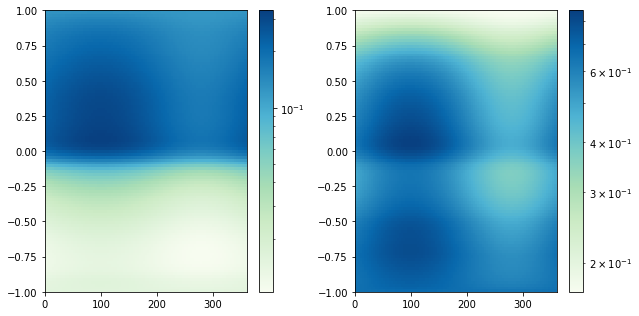

In [133]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4.5))


print(phi100s[14], gammas[1], A_dipole[2])
vals = F['icecube'][...,14,1,0].T
print('vals', np.sum(vals))



for i, exp in enumerate(['icecube', 'plenum']):
    ax = axes[i]
    p = ax.pcolormesh( np.degrees(ra_bins), sindec_bins, F[exp][...,14,1,7], 
                      cmap='GnBu', norm=LogNorm() 
                  )
    fig.colorbar(p, ax=ax)

fig.tight_layout()


idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
w = (idata['astro'])*lt 
print('icecube', np.sum(w))

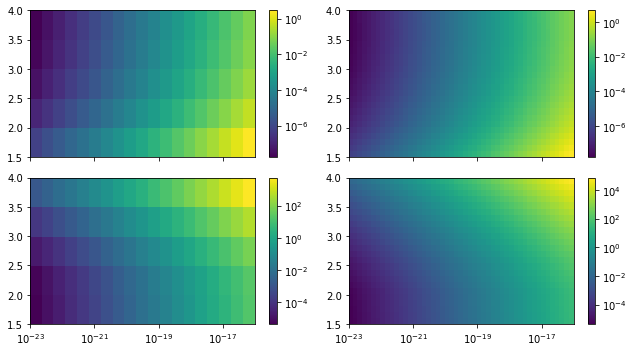

In [134]:
import scipy
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9,5), sharex=True)

Signal_Splines = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    fexp =np.zeros((n_sindec, len(ra_mids) ,
                        len(phi100s), len(gammas), len(A_dipole)),
                       dtype=float)
    F_template = copy(F[exp])
    F_template[F_template==0] = 1e-15

    binmids = (sindec_mids, ra_mids, phi100s, gammas, A_dipole)
    spline_sig = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(F_template),
                    method="linear",
                    bounds_error=False,
                    fill_value=-15,
                    )

    Signal_Splines[exp] = spline_sig
    ax = axes[k,0]
                   
    p = ax.pcolormesh(phi100s, gammas, F_template[3,5,...,0].T, norm=LogNorm(), )
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

    ax = axes[k,1]
    _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )
    _gs = np.linspace(np.min(gammas), np.max(gammas), 25)
    xx, yy = np.meshgrid(_phis, _gs, indexing='ij')
    spline_res = np.exp(spline_sig((sindec_mids[3], ra_mids[5], xx,yy, A_dipole[0]  )))


    p = ax.pcolormesh(_phis, _gs, spline_res.T, norm=LogNorm())
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

fig.tight_layout()

# Generate a function that allows to generate radndom trials 

In [127]:
XX,YY = np.meshgrid(sindec_mids, ra_mids, indexing='ij')
def conv_func_signal(log10_phi100, gamma, a_dipole, spline):
    _phi100 = 10**np.atleast_1d(log10_phi100)
    gamma = np.atleast_1d(gamma)
    a_dipole = np.atleast_1d(a_dipole)
    
    #print(_phi100, gamma,a_dipole)
    #res = np.exp(spline((XX.flatten(),YY.flatten(),
    #                      _phi100[:,np.newaxis], gamma[:,np.newaxis], 
    #                      a_dipole[:,np.newaxis] )))
    
    res = np.exp(spline((XX,YY,
                          _phi100, gamma, 
                          a_dipole )))
    #print('here',res.shape)
    return res
    #return res.reshape((len(_phi100),)+XX.shape)

In [128]:
def LambdaTS(log10_phi100, gamma, a_dipole, data, lambda_b, spline):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    lambda_s = conv_func_signal(log10_phi100, gamma, a_dipole, spline)
    r = lambda_s / lambda_b #background expectation should not be 0    
    _mask = lambda_b == 0
    r[_mask] = 0
    res = 2 * np.sum(np.log(1+r) * data - lambda_s)#, axis=(1,2))
    return res

In [135]:
# Now start with a simple llh scan of one expectation
phi_exp = 1.44e-18
gamma_exp = 2.28
a_dip_exp = 0.25

lambda_bckg = Res_numu_reco['plenum']
lambda_sig = conv_func_signal(np.log10(phi_exp), gamma_exp, a_dip_exp, Signal_Splines['plenum'])
d_tot = lambda_bckg+lambda_sig


In [98]:
idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
w = (idata['conv']+idata['prompt'])*lt #* idata['trueE']**(-gamma)
print('icecube conv', np.sum(w))
w = (idata['astro'])*lt #* idata['trueE']**(-gamma)
print('icecube astro', np.sum(w))

icecube conv 755411.406648681
icecube astro 1375.0699041580347


In [112]:
print(np.sum(lambda_bckg))
print(np.sum(Res_numu_reco['icecube']))
print(np.sum(lambda_sig))

3488922.2147599244
793837.8950173687
6167.113019286842


In [136]:
_adips = np.linspace(A_dipole[0], A_dipole[-1], 50)

TS_1d = dict() 
for exp in ['icecube', 'plenum']:
    ts_vals_1d = np.zeros_like(_adips, dtype=float)
    Lambda_best = LambdaTS(np.log10(phi_exp), gamma_exp, a_dip_exp, d_tot, lambda_bckg, 
                              spline=Signal_Splines[exp])
    print('lb', Lambda_best)
    for i, zi in enumerate(_adips):

        ts_vals_1d[i] = (LambdaTS(np.log10(phi_exp), gamma_exp, zi, d_tot, lambda_bckg, 
                              spline=Signal_Splines[exp])
                      - Lambda_best)
        
        
    TS_1d[exp] = ts_vals_1d

lb 7.897360597597557
lb 24.164228984671517


(0.0, 0.3)

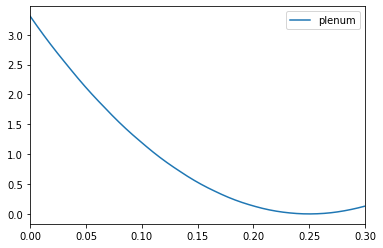

In [139]:
fig, ax = plt.subplots()

for exp in ['icecube', 'plenum']:
    if exp=='icecube':
        continue
    ax.plot(_adips, -TS_1d[exp], label=exp)
    
#ax.axvline(a_dip_exp)
ax.legend()
#ax.set_ylim(0, 5)#np.max(-TS_1d['plenum']))
ax.set_xlim(0,0.3)

In [ ]:
XX,YY = np.meshgrid(sindec_mids, ra_mids, indexing='ij')
def conv_func_signal(log10_phi100, gamma, a_dipole, spline):
    _phi100 = 10**np.atleast_1d(log10_phi100)
    gamma = np.atleast_1d(gamma)
    a_dipole = np.atleast_1d(a_dipole)
    return np.exp(spline((XX,YY,_phi100[np.newaxis,...], gamma[np.newaxis,...], a_dipole[np.newaxis,...] )))

In [ ]:
rand = np.random.RandomState(0)
def generate_bckg_data(lambda_b, n_trials):
    print(lambda_b.flatten().shape)
    out = rand.poisson(lambda_b.flatten(), size=(n_trials, len(lambda_b.flatten())))
    print(out.shape)
    return out

def generate_signal_data(log10_phi100, gamma0, gamma1, n_trials, spline):
    lambda_s = conv_func_broken_pl(log10_phi100, gamma0, gamma1, spline)[0]
    out = rand.poisson(lambda_s, size=(n_trials, len(lambda_s)))
    return out

In [ ]:
res = conv_func_signal([-19.,-18.], [2.1,2.1],[0.1,0.2], spline=Signal_Splines['plenum']
                      )

In [ ]:
res.shape

In [ ]:
fexp.shape

In [ ]:
lambda_b = Res_mu_reco['plenum']
generate_bckg_data(lambda_b, 2)